# TP : Proximal coordinate descent method on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 17 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [41]:
# Change here using YOUR first and last names
fn1 = "salma"
ln1 = "el-alaoui-talibi"
fn2 = "sophia"
ln2 = "lazraq"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_el-alaoui-talibi_salma_and_lazraq_sophia.ipynb


In [42]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
#from scipy import linalg

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

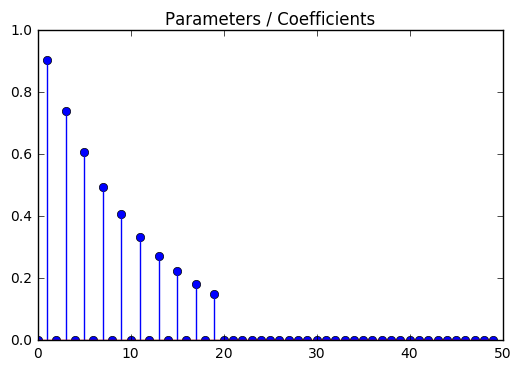

In [44]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")


### Functions for the simulation of the models

In [45]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}_+$, where $g(x) = i_{x \geq 0}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$


## Questions

### Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases


In [46]:
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    lasso = s * np.linalg.norm(x, ord = 1)
    return lasso

def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t""" 
    x_abs = np.absolute(x)
    prox_lasso = np.sign(x) * (x_abs - t * s) * (x_abs > t * s)
    return prox_lasso

def indicator(x, s=1.):
    """ Indicator function of R+ """
    if np.any(x < 0):
        return np.inf
    return 0

def prox_indicator(x, s=1., t=1.):
    """ projection on R+ """
    if(x.shape):
        x = x.copy()
        x[x < 0] = 0
        return x
    else:
        return max(x, 0)

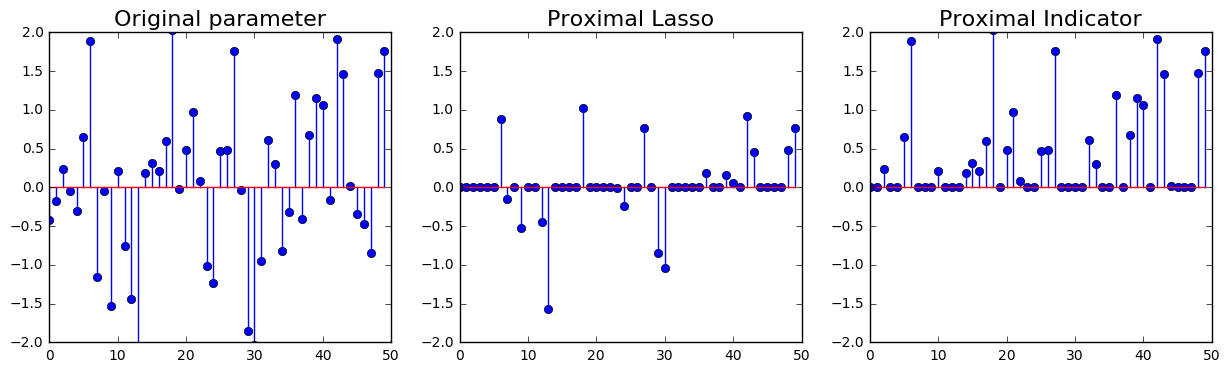

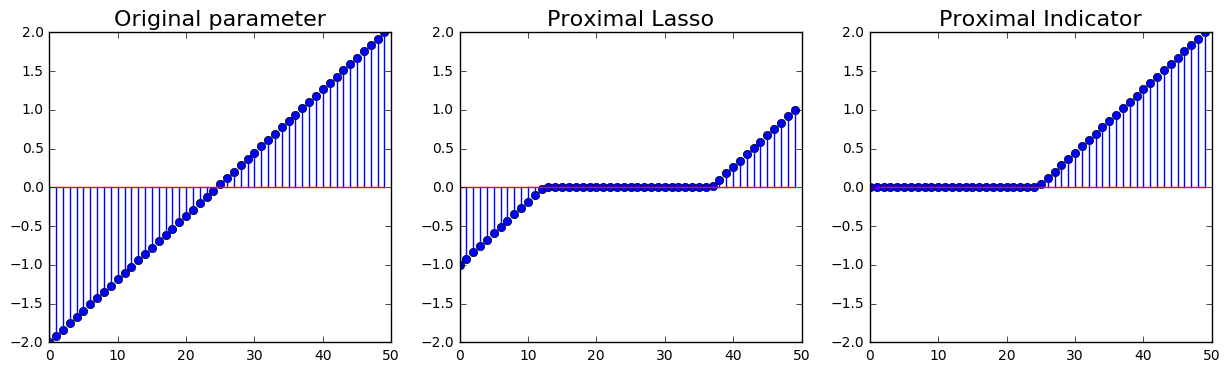

In [47]:
def prox_viz(x):
    l_l1 = 1.
    l_l2 = 0.5
    plt.figure(figsize=(15.0, 4.0))
    plt.subplot(1, 3, 1)
    plt.stem(x)
    plt.title("Original parameter", fontsize=16)
    plt.ylim([-2, 2])
    plt.subplot(1, 3, 2)
    plt.stem(prox_lasso(x, s=l_l1))
    plt.title("Proximal Lasso", fontsize=16)
    plt.ylim([-2, 2])
    plt.subplot(1, 3, 3)
    plt.stem(prox_indicator(x))
    plt.title("Proximal Indicator", fontsize=16)
    plt.ylim([-2, 2])
    plt.show()

prox_viz(randn(50))
prox_viz(np.linspace(-2,2))

### Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- $\frac{1}{2} \|b - Ax\|^2$ is convex and differentiable
- For lasso penalization: $g(x) = s \|x\|_1 = \sum_{i=1}^{p}|x_i| $, and each $|x_i|$ is convex 
- For Indicator function of $\mathbb{R}_+^p$: $g(x) = i_{x \geq 0}(\cdot) = \sum_{i=1}^{p} i_{x_i \geq 0}(\cdot) $
and each $i_{x_i \geq 0}(\cdot)$ is convex because $\mathbb{R}_+$ is convex. Indeed:
$$\forall x_1, x_2 \in \mathbb{R}_+, \forall \theta_1 \geq 0, \theta_2 \geq 0, \theta_1 + \theta_2 = 1 : \theta_1x_1 + \theta_2x_2 \in \mathbb{R}_+$$

### Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.


In [48]:
def objective(x, A, b, g, s):
    """ Objective F(x) = 1/2 ||b−Ax||^2 + s * g(x) """
    return 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)

def gradient_i(x, A, b, i):
    """ gradient of 1/2 ||b−Ax||^2 for the coordinate i"""
    return np.dot(A[:, i].T, np.dot(A, x) - b)

def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coodinate descent.
    """
    
    Li = np.sum(A * A, axis=0)
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)

    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    for k in range(n_iter):
        i = k % n_features
        x[i] -= 1. / Li[i] * gradient_i(x, A, b, i)
        x[i] = prox_g(x=x[i], s=s, t=1. / Li[i])
        obj = objective(x, A, b, g, s)
        objectives.append(obj) 
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [49]:
def plot_convergence_plot(x0, A, b, g, prox_g, s, n_iter, x_true, method):
    penalty = g.__name__
    method_name = method.__name__
    if method_name == "cd_linreg":
        title = "Convergence plots for Coordinate Descent for "+ penalty + " penalty"
    else:
        title = "Convergence plots for Coordinate Descent with residual updates for "+ penalty + " penalty"
    x_precise, _, _ = method(x0=x0, A=A, b=b, g=g, prox_g=prox_g, s=s, n_iter=10000, x_true=coefs, verbose=False)
    _, objectives, errors= method(x0=x0, A=A, b=b, g=g, prox_g=prox_g, s=s, n_iter=n_iter, x_true=coefs, verbose=False)
    plt.figure(figsize=(15.0, 4.0))
    plt.subplot(1, 2, 1)
    obj_star = objective(x_precise, A, b, g, s=s)
    plt.semilogy((np.array(objectives) - obj_star), label="CD")
    plt.xlabel('iterations (t)')
    plt.ylabel(r'$\log(F(x^t) - F(x^*))$', size=12)
    plt.subplot(1, 2, 2)
    plt.semilogy(np.array(objectives), label="CD")
    plt.xlabel('iterations (t)')
    plt.ylabel(r'$\log(F(x^t))$', size=12)
    plt.suptitle(title, size=14, y=1.1)

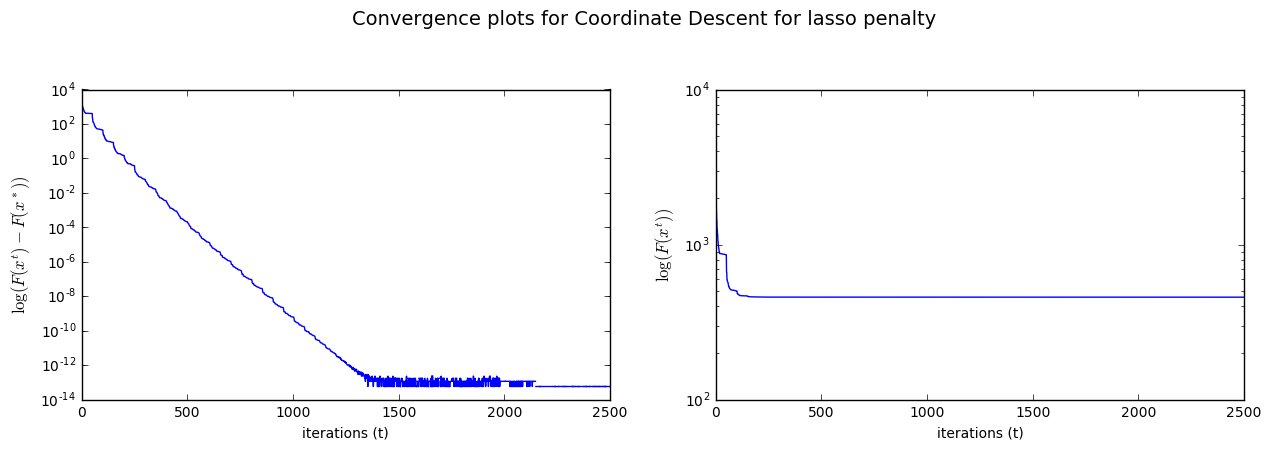

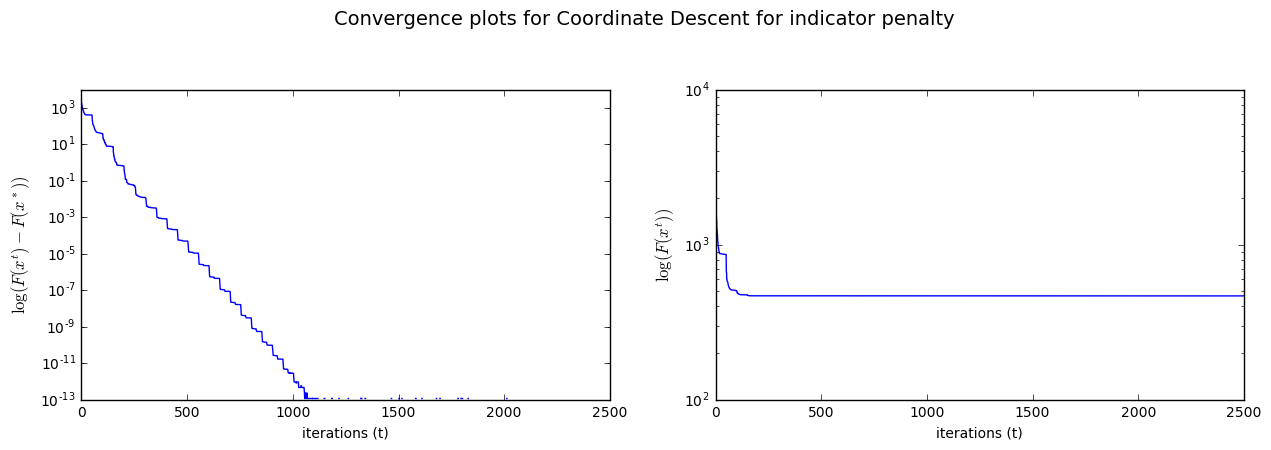

In [65]:
A,b = simu_linreg(coefs)
x0 = np.zeros(n_features)
s=1e-2
n_iter = n_features * 50
plot_convergence_plot(x0, A, b, lasso, prox_lasso, s, n_iter, coefs, cd_linreg)
plot_convergence_plot(x0, A, b, indicator, prox_indicator, s, n_iter, coefs, cd_linreg)

We notice that for both penalties, $\log(F(x^t) - F(x^*))$ has plateau and then a sharp drop every 50 iterations.
It's an artifact of the data and the fact that we use cyclic rule in coordiante descent. The good features(non zero) are at the beginning, so the $\log(F(x^t) - F(x^*))$ decreases when we handle them and then plateaus for the rest of the pass on the data.

### Implementation of coordiante descente using the smart residual updates

In [66]:
def smart_cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coodinate descent with the smart residuals updates.
    """
    
    Li = np.sum(A * A, axis=0)
    x = x0.copy()
    # vector for the residuals
    r = b.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)

    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    for k in range(n_iter):
        i = k % n_features
        Ai = A[:, i]
        r += Ai * x[i]
        x[i] = (np.dot(Ai.T, r)/np.dot(Ai, Ai))
        x[i] = prox_g(x=x[i], s=s, t=1. / Li[i])
        r -= Ai * x[i]
        obj = objective(x, A, b, g, s)
        objectives.append(obj) 
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

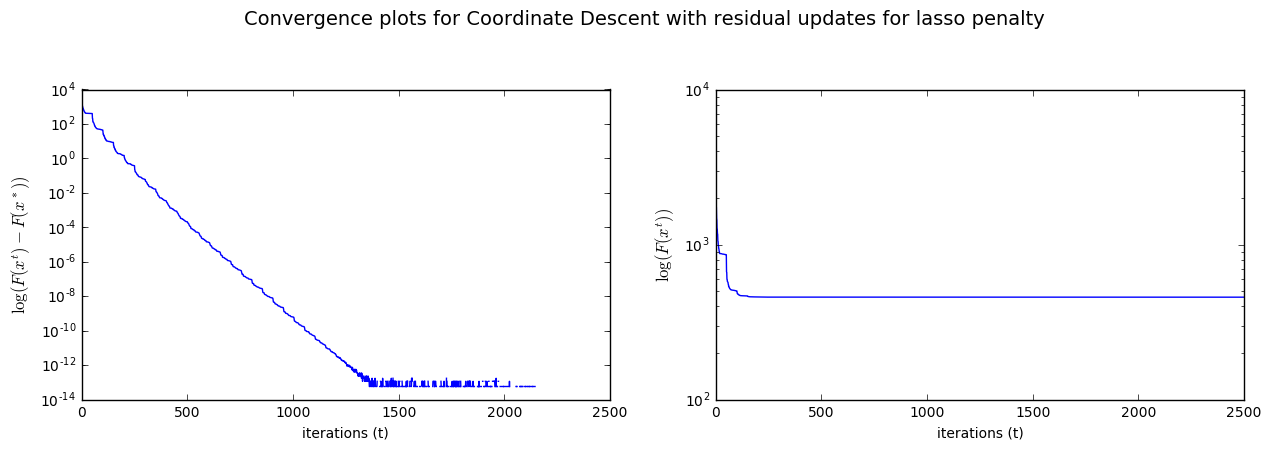

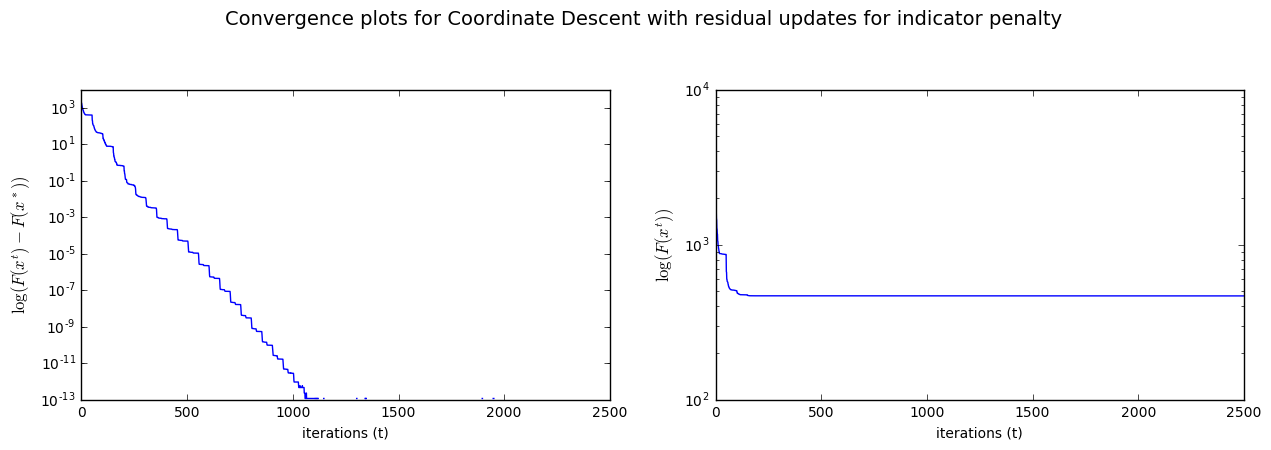

In [67]:
plot_convergence_plot(x0, A, b, lasso, prox_lasso, s, n_iter, coefs, smart_cd_linreg)
plot_convergence_plot(x0, A, b, indicator, prox_indicator, s, n_iter, coefs, smart_cd_linreg)


In order to compare the execution times of the two implementations of coordinate descent, we change the dimensions of the dataset. Namely, we use a bigger number of features since we are supposed to go from O(n(p-1)^2) to O(pn) with the smart residual updates (with p being the number of features and n the number of samples).

In [53]:
n_features = 1000
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[n_features/2:] = 0.
A,b = simu_linreg(coefs)
x0 = np.zeros(n_features)
s=1e-2

print("CD")
%timeit cd_linreg(x0, A, b, lasso, prox_lasso, s=s, n_iter=10000, x_true=coefs, verbose=False)
print("CD with smart residual updates")
%timeit smart_cd_linreg(x0, A, b, lasso, prox_lasso, s=s, n_iter=10000, x_true=coefs, verbose=False)

/Users/salma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CD
1 loop, best of 3: 13 s per loop
CD with smart residual updates
1 loop, best of 3: 6.73 s per loop


We see that indeed there is an improvement in the execution speed.

Now we go back to the previous coefficient model and compare the lasso and indicator solutions

In [54]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.

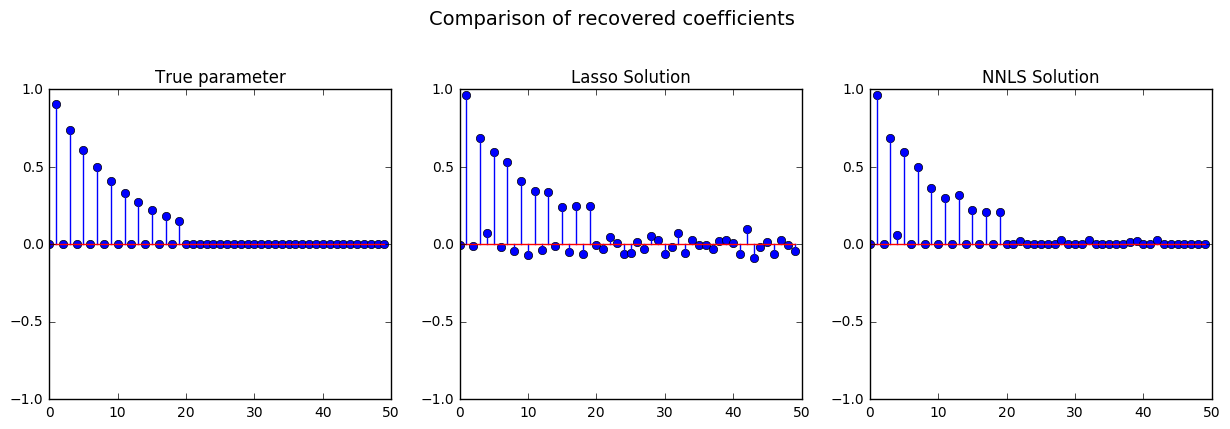

In [55]:
A,b = simu_linreg(coefs)
x0 = np.zeros(n_features)
s=1e-2
x_lasso, _, _ = smart_cd_linreg(x0, A, b, lasso, prox_lasso, s=s, n_iter=10000, x_true=coefs, verbose=False)
x_indicator, _, _ = smart_cd_linreg(x0, A, b, indicator, prox_indicator, s=s, n_iter=10000, x_true=coefs, verbose=False)
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.ylim([-1, 1])
plt.title("True parameter")
plt.subplot(1, 3, 2)
plt.stem(x_lasso)
plt.ylim([-1, 1])
plt.title("Lasso Solution")
plt.subplot(1, 3, 3)
plt.stem(x_indicator)
plt.ylim([-1, 1])
plt.title("NNLS Solution")
plt.suptitle("Comparison of recovered coefficients", y =1.1, size=14)

We can see that in the non-negative least squares (NNLS) solution, the coefficients are not allowed to become negative, while the Lasso solution induces sparsity.

### Evaluate qualitatively the convergence when varying the conditioning of the problem.

We vary the correlation (the covariance of A), and compare the convergence rates for different values. We also compare the convergence rates for different values of the condition number of A in the next question.

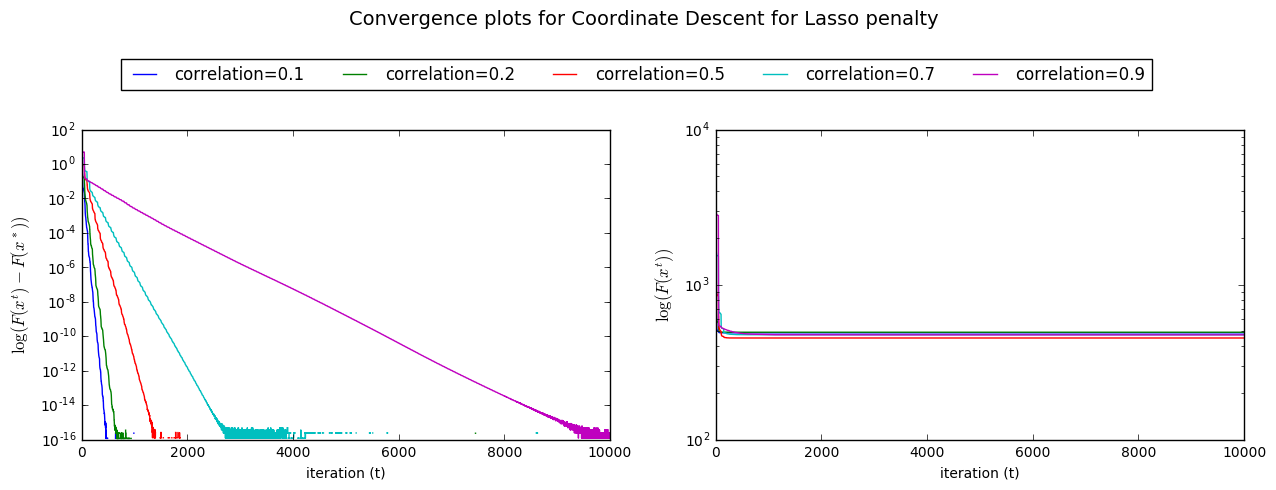

In [56]:

x0 = np.zeros(n_features)
s=1e-2
n_iter=200*n_features
corr_values= [0.1, 0.2, 0.5, 0.7, 0.9]
plt.figure(figsize=(15.0, 4.0))
for corr in corr_values:
    A,b = simu_linreg(coefs, corr=corr)
    title = "Convergence plots for Coordinate Descent for "+ "Lasso" + " penalty"
    x_precise, _, _ = cd_linreg(x0=x0, A=A, b=b, g=lasso, prox_g=prox_lasso, s=s, n_iter=10000, x_true=coefs, 
                                verbose=False)
    _, objectives, _= cd_linreg(x0=x0, A=A, b=b, g=lasso, prox_g=prox_lasso, s=s, n_iter=n_iter, x_true=coefs, 
                                verbose=False)
    plt.subplot(1, 2, 1)
    obj_star = objective(x_precise, A, b, lasso, s=s)
    plt.semilogy((np.array(objectives) - obj_star)/np.abs(obj_star), label="correlation=" + str(corr))
    plt.xlabel('iteration (t)')
    plt.ylabel(r'$\log(F(x^t) - F(x^*))$', size=12)
    plt.subplot(1, 2, 2)
    plt.semilogy((np.array(objectives)), label="correlation=" + str(corr))
    plt.xlabel('iteration (t)')
    plt.ylabel(r'$\log(F(x^t))$', size=12)
    plt.legend(bbox_to_anchor=(-0.15, 1.1), loc='lower center', ncol=len(corr_values))
    plt.suptitle(title, size=14, y=1.2)
plt.show()
    

The left handside plot shows that for all correlation values, we have a linear convergence rate (the error decay on this logarithmic scale is linear with a negative slope), but the slope is much steeper for smaller values of correlation.

### Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.


In order to compare the effect of bad conditioning on Coordinate Descent and Gradient Descent, we generate matrices with different condition numbers, and compare the convergence rates.
The condition number of A is:
$$\frac{L}{\mu} = \frac{\lambda_{max}(A)}{\lambda_{min}(A)}$$

Therefore, in order to generate a matrix with a desired condition number, we use SVD and modify the matrix with the singular values.

In [63]:
def generate_matrix_condition_number(A, condition_number):
    U, s, V = np.linalg.svd(A, full_matrices=False)
    s = np.linspace(condition_number, 1, n_features);
    S = np.diag(s)
    A_new = np.dot(U, np.dot(S, V))
    b_new = A.dot(coefs) + randn(n_samples)
    #print (np.linalg.cond(A_new))
    return A_new, b_new

In [61]:
def loss_linreg(x, A, b):
    """ 1/2 ||b−Ax||^2 """
    n_samples = A.shape[0]
    return 0.5 * np.linalg.norm(b - np.dot(A, x)) ** 2

def grad_linreg(x, A, b):
    """ gradient of 1/2 ||b−Ax||^2 """
    n_samples = A.shape[0]
    return np.dot(np.transpose(A), np.dot(A, x) - b)

def lip_linreg(A):
    """ Lipschitz constant for linear square loss """
    n_samples = A.shape[0]
    return np.linalg.norm(np.dot(np.transpose(A), A), ord=2)


def ista(A, b, x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """
        Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x, A, b) + g(x, s)
    objectives.append(obj)
    
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err", "err objective"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(x=x - step * grad_f(x, A, b), s=s, t=step)
        x = x_new
        obj = f(x, A, b) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

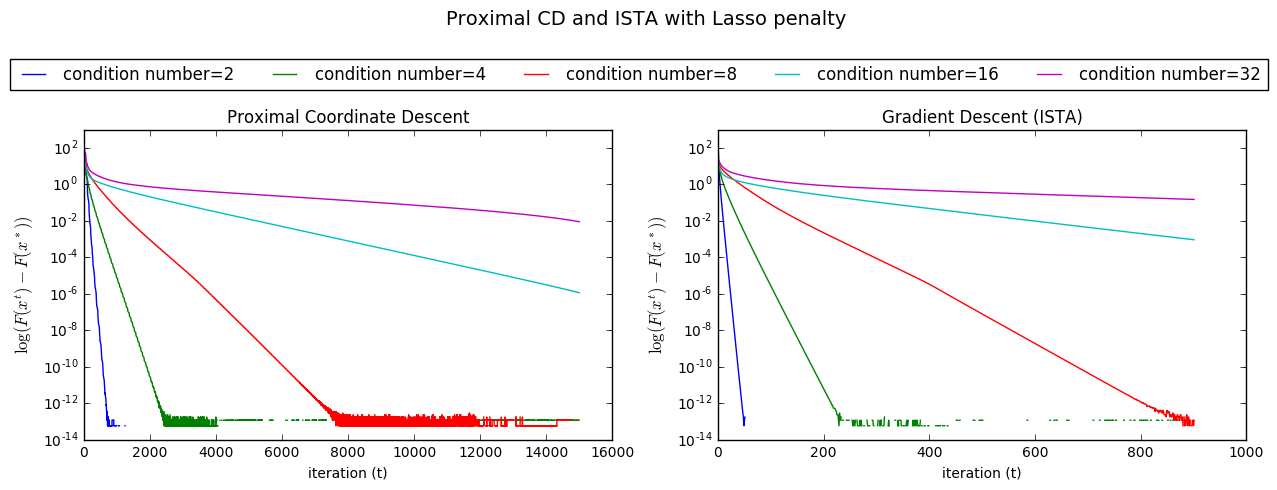

In [64]:
A_base,_ = simu_linreg(coefs)
x0 = np.zeros(n_features)
s=1e-2
n_iter_ista = 300
n_iter_cd = n_iter_ista *n_features
condition_numbers= [2, 4, 8, 16, 32]
plt.figure(figsize=(15.0, 4.0))
for nb in condition_numbers:
    A, b = generate_matrix_condition_number(A, nb)
    step =1./lip_linreg(A)
    x_precise, _, _ = ista(A=A, b=b, x0=x0, f=loss_linreg, grad_f=grad_linreg, g=lasso, prox_g=prox_lasso,
                                    step=step, s=s, n_iter=2000, x_true=coefs, verbose=False)
    _, objectives, _= smart_cd_linreg(x0=x0, A=A, b=b, g=lasso, prox_g=prox_lasso, s=s, n_iter=n_iter_cd, 
                                      x_true=coefs, verbose=False)
    obj_star = objective(x_precise, A, b, lasso, s=s)
    plt.subplot(1, 2, 1)
    plt.semilogy(np.array(objectives) - obj_star, label="condition number=" + str(nb))
    plt.xlabel('iteration (t)')
    plt.ylabel(r'$\log(F(x^t) - F(x^*))$', size=12)
    plt.title("Proximal Coordinate Descent")
    plt.subplot(1, 2, 2)
    _, objectives_ista, _ = ista(A=A, b=b, x0=x0, f=loss_linreg, grad_f=grad_linreg, g=lasso, prox_g=prox_lasso,
                                    step=step, s=s, n_iter=n_iter_ista * 3, x_true=coefs, verbose=False)
    plt.semilogy(np.array(objectives_ista) - obj_star, label="condition number=" + str(nb))
    plt.xlabel('iteration (t)')
    plt.ylabel(r'$\log(F(x^t) - F(x^*))$', size=12)
    plt.legend(bbox_to_anchor=(-0.15, 1.1), loc='lower center', ncol=len(condition_numbers))
    plt.title("Gradient Descent (ISTA)")
    plt.suptitle("Proximal CD and ISTA with Lasso penalty", size=14, y=1.2)
plt.show()
                          
   
    

**(End previous question)** We can see once again that the conditioning of the problem affects the speed of convergence for CD, as the slope is much steeper for good conditining (small values of the condition number).

We can also see that for a small condition number (2), the **number of iterations necessary to reach convergence** for CD is about 20 times larger than for ISTA. But we can see that when we increase the condition number, the ratio (iterations CD/ iterations ISTA) decreases : for example, when the condion number is 4 the ratio only about 10, so GD is more sensitive to conditioning than CD. Indeed, when the condition number is large it leads to many evaluations of full gradients in GD, which is computationnely expensive and results in much slower convergence for GD than for CD.